100%|██████████| 170M/170M [00:04<00:00, 34.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


CCT Training Epoch 30: 100%|██████████| 391/391 [00:30<00:00, 12.94it/s]


ViT Total Training Time: 653.24 seconds
CCT Total Training Time: 662.52 seconds


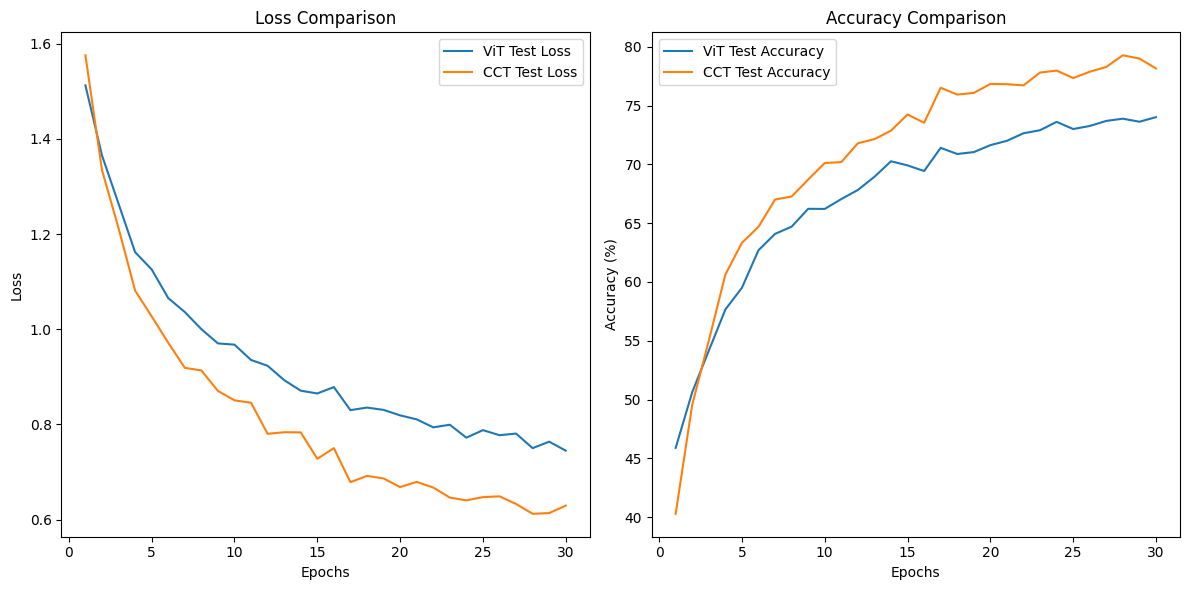

ViT Parametre Sayısı: 4542346
CCT Parametre Sayısı: 333834


In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

# Hyperparameters
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 30
image_size = 32
num_classes = 10

# Data preparation
transform = transforms.Compose([
    transforms.RandomCrop(image_size, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Helper functions for models
class Patches(nn.Module):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def forward(self, images):
        batch_size, channels, height, width = images.size()
        patches = images.unfold(2, self.patch_size, self.patch_size)
        patches = patches.unfold(3, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(batch_size, channels, -1, self.patch_size, self.patch_size)
        patches = patches.permute(0, 2, 3, 4, 1).contiguous()
        patches = patches.view(batch_size, -1, self.patch_size * self.patch_size * channels)
        return patches

class PatchEncoder(nn.Module):
    def __init__(self, patch_size, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.projection = nn.Linear(patch_size * patch_size * 3, projection_dim)
        self.position_embedding = nn.Parameter(torch.zeros(1, num_patches, projection_dim))

    def forward(self, patches):
        positions = self.position_embedding
        return self.projection(patches) + positions


class ViT(nn.Module):
    def __init__(self):
        super(ViT, self).__init__()
        patch_size = 4  # Burada patch_size'ı tanımlıyoruz
        num_patches = (image_size // patch_size) ** 2
        projection_dim = 128

        self.patches = Patches(patch_size)
        self.encoder = PatchEncoder(patch_size, num_patches, projection_dim)
        self.transformer_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=projection_dim,
                nhead=2,
                dim_feedforward=projection_dim,
                dropout=0.1
            ) for _ in range(2)
        ])
        self.flatten = nn.Flatten()
        self.mlp_head = nn.Sequential(
            nn.Linear(projection_dim * num_patches, projection_dim * 4),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(projection_dim * 4, projection_dim * 2),
            nn.GELU(),
            nn.Dropout(0.5),
        )
        self.classifier = nn.Linear(projection_dim * 2, num_classes)

    def forward(self, x):
        patches = self.patches(x)
        encoded_patches = self.encoder(patches)

        for layer in self.transformer_layers:
            encoded_patches = layer(encoded_patches)

        representation = self.flatten(encoded_patches)
        features = self.mlp_head(representation)
        return self.classifier(features)


class CCT(nn.Module):
    def __init__(self):
        super(CCT, self).__init__()
        self.tokenizer = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        self.position_embedding = nn.Parameter(torch.zeros(1, 64, 128))
        self.transformer_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=128, nhead=2, dim_feedforward=128, dropout=0.1
            ) for _ in range(2)
        ])
        self.pooling = nn.Linear(128, 128)
        self.mlp_head = nn.Sequential(
            nn.Linear(128, 128),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(128, 128),
            nn.GELU(),
            nn.Dropout(0.5),
        )
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.tokenizer(x)
        batch_size, channels, height, width = x.size()
        x = x.view(batch_size, channels, -1).permute(0, 2, 1)
        x = x + self.position_embedding[:, :x.size(1), :]

        for layer in self.transformer_layers:
            x = layer(x)

        x = x.mean(dim=1)
        x = self.mlp_head(x)
        return self.classifier(x)

def train_and_evaluate_model(model, model_name, train_loader, test_loader, num_epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0
        for images, labels in tqdm(train_loader, desc=f"{model_name} Training Epoch {epoch + 1}"):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(100. * correct / total)

        model.eval()
        test_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        test_losses.append(test_loss / len(test_loader))
        test_accuracies.append(100. * correct / total)

    return train_losses, test_losses, train_accuracies, test_accuracies

# Train and evaluate both models
vit_model = ViT()
cct_model = CCT()

vit_results = train_and_evaluate_model(vit_model, "ViT", train_loader, test_loader, num_epochs)
cct_results = train_and_evaluate_model(cct_model, "CCT", train_loader, test_loader, num_epochs)

import time

# Time measurement function
def measure_training_time(model, model_name, train_loader, num_epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    end_time = time.time()

    total_time = end_time - start_time
    print(f"{model_name} Total Training Time: {total_time:.2f} seconds")
    return total_time

# Measuring training times
vit_time = measure_training_time(ViT(), "ViT", train_loader, num_epochs)
cct_time = measure_training_time(CCT(), "CCT", train_loader, num_epochs)


# Plot results
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
# plt.plot(epochs, vit_results[0], label="ViT Train Loss")
plt.plot(epochs, vit_results[1], label="ViT Test Loss")
# plt.plot(epochs, cct_results[0], label="CCT Train Loss")
plt.plot(epochs, cct_results[1], label="CCT Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Comparison")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
# plt.plot(epochs, vit_results[2], label="ViT Train Accuracy")
plt.plot(epochs, vit_results[3], label="ViT Test Accuracy")
# plt.plot(epochs, cct_results[2], label="CCT Train Accuracy")
plt.plot(epochs, cct_results[3], label="CCT Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Comparison")
plt.legend()

plt.tight_layout()
plt.show()

# Function to calculate the number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Calculate the number of parameters of ViT and CCT models
vit_model = ViT()
cct_model = CCT()

vit_params = count_parameters(vit_model)
cct_params = count_parameters(cct_model)

print(f"ViT Parameter Count: {vit_params}")
print(f"CCT Parameter Count: {cct_params}")